In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import xgboost as xgb
import time
import random
import pickle
from sklearn.metrics import mean_squared_log_error

In [37]:
st = time.time()
train_data = pd.read_csv('preprocessed_train_data.csv')
test_data = pd.read_csv('preprocessed_test_data.csv')
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(train_data.shape)
print(test_data.shape)
print("Reading train and test data. Done!!!")

Execution time: 11.10407018661499 seconds
(1092428, 31)
(364143, 31)
Reading train and test data. Done!!!


In [45]:
test_data.iloc[1]

vendor_id                      2
passenger_count                2
pickup_longitude      -73.982224
pickup_latitude        40.773182
dropoff_longitude     -73.993866
dropoff_latitude       40.756718
store_and_fwd_flag             N
trip_duration               1338
pickup_hour                   20
pickup_day                    17
pickup_day_of_week             3
pickup_month                   3
pickup_weekyear               11
haversine_dist          2.076778
bearing_dist         -151.823534
geodesic_dist           0.350427
euclidean_dist          0.003296
manhattan_dist          0.004417
chebyshev_dist          0.002953
canberra_dist           0.000046
sqeuclidean_dist        0.000011
cosine_dist                  0.0
braycurtis_dist         0.000019
pickup_boro            Manhattan
pickup_nta                  MN14
dropoff_boro           Manhattan
dropoff_nta                 MN15
pickup_pop               61489.0
pickup_area             1.468418
dropoff_pop              45884.0
dropoff_ar

In [3]:
st = time.time()
corrmat = np.round(train_data.corr(),3)
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop.append('sqeuclidean_dist')
noncoll_train_data = train_data.drop(to_drop,axis=1)
noncoll_test_data = test_data.drop(to_drop,axis=1)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(noncoll_train_data.shape)
print(to_drop)
print("Dropping columns to avoid collinearity problem. Done!!!")    

C:\Users\arunt\AppData\Local\Temp\ipykernel_14976\2118416476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = np.round(train_data.corr(),3)
C:\Users\arunt\AppData\Local\Temp\ipykernel_14976\2118416476.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))


Execution time: 4.00979471206665 seconds
(1092428, 24)
['geodesic_dist', 'euclidean_dist', 'manhattan_dist', 'chebyshev_dist', 'canberra_dist', 'braycurtis_dist', 'sqeuclidean_dist']
Dropping columns to avoid collinearity problem. Done!!!


In [ ]:
noncoll_train_data.dtypes

In [4]:
st = time.time()
ohe = OneHotEncoder(handle_unknown='ignore')
categorical_features = ['passenger_count','vendor_id','store_and_fwd_flag','pickup_day','pickup_month','pickup_hour','pickup_weekyear','pickup_day_of_week','pickup_boro','pickup_nta','dropoff_boro','dropoff_nta']
for i in categorical_features:
    noncoll_train_data[i]=noncoll_train_data[i].astype('object')
    noncoll_test_data[i]=noncoll_test_data[i].astype('object')  
train_cat = noncoll_train_data.select_dtypes('object')
test_cat = noncoll_test_data.select_dtypes('object')
train_cat_features = ohe.fit_transform(train_cat).toarray()
train_feature_names = ohe.get_feature_names_out(train_cat.columns.values)
test_cat_features = ohe.transform(test_cat).toarray()
test_feature_names = ohe.get_feature_names_out(test_cat.columns.values)
train_ohe = pd.concat([noncoll_train_data.select_dtypes(exclude='object'), 
            pd.DataFrame(train_cat_features,columns=train_feature_names).astype(int)], axis=1)
test_ohe = pd.concat([noncoll_test_data.select_dtypes(exclude='object'), 
            pd.DataFrame(test_cat_features,columns=test_feature_names).astype(int)], axis=1)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(train_ohe.shape)
print(test_ohe.shape)

Execution time: 56.05523443222046 seconds
(1092428, 514)
(364143, 514)


In [5]:
print(train_cat.shape)
print(test_cat.shape)

(1092428, 12)
(364143, 12)


In [ ]:
st = time.time()
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_ohe)
X_test_ss = ss.transform(X_test_ohe)
y_train = train_ohe['trip_duration'].values
y_test = test_ohe['trip_duration'].values
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(X_train_ss.shape)
print(X_test_ss.shape)
print("Feature Scaling. Done!!!")

In [ ]:
test_cat.columns.values

In [ ]:
test_feature_names

In [9]:
len(test_ohe.columns.values)

514

In [ ]:
from pickle import dump
dump(ohe, open('ohe.pkl', 'wb'))

In [ ]:
from pickle import load
ohe_new = load(open('ohe.pkl', 'rb'))

In [ ]:
test_cat.iloc[:1]

In [ ]:
ohe_new.categories_

In [ ]:
test_feature_names

In [ ]:
noncoll_test_data.iloc[0].values

In [ ]:
test_cat_features[0]

In [ ]:
# prediction
def final_function1(mylist):
    # Reading the train and test data with all the variables
    st = time.time()
    train_data = pd.read_csv('preprocessed_train_data.csv')
    test_data = pd.read_csv('preprocessed_test_data.csv')
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(train_data.shape)
    print(test_data.shape)
    print("Reading train and test data. Done!!!")
    
    # Dropping features with very high correlations
    st = time.time()
    corrmat = np.round(train_data.corr(),3)
    upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
    to_drop.append('sqeuclidean_dist')
    noncoll_train_data = train_data.drop(to_drop,axis=1)
    noncoll_test_data = test_data.drop(to_drop,axis=1)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(noncoll_train_data.shape)
    print(noncoll_test_data.shape)
    print("Dropping columns to avoid collinearity problem. Done!!!")
    
    # Imputing missing data using KNN imputer
    st = time.time()
    g = noncoll_train_data[['pickup_area','pickup_pop','dropoff_area','dropoff_pop']].values
    h = noncoll_test_data[['pickup_area','pickup_pop','dropoff_area','dropoff_pop']].values
    knn_imputer = KNNImputer(n_neighbors=3)
    st = time.time()
    new_train_data = knn_imputer.fit_transform(g)
    new_test_data = knn_imputer.transform(h)
    noncoll_train_data['pickup_area'] = new_train_data[::,0]
    noncoll_train_data['pickup_pop'] = new_train_data[::,1]
    noncoll_train_data['dropoff_area'] = new_train_data[::,2]
    noncoll_train_data['dropoff_pop'] = new_train_data[::,3]
    noncoll_test_data['pickup_area'] = new_test_data[::,0]
    noncoll_test_data['pickup_pop'] = new_test_data[::,1]
    noncoll_test_data['dropoff_area'] = new_test_data[::,2]
    noncoll_test_data['dropoff_pop'] = new_test_data[::,3]
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(noncoll_train_data.shape)
    print(noncoll_test_data.shape)
    print("Imputing missing data. Done!!!")
    
    # Using OHE to convert categorical to numerical features
    st = time.time()
    ohe = OneHotEncoder(handle_unknown='ignore')
    categorical_features = ['passenger_count','vendor_id','store_and_fwd_flag','pickup_day','pickup_month','pickup_hour','pickup_weekyear','pickup_day_of_week','pickup_boro','pickup_nta','dropoff_boro','dropoff_nta']
    for i in categorical_features:
        noncoll_train_data[i]=noncoll_train_data[i].astype('object')
        noncoll_test_data[i]=noncoll_test_data[i].astype('object')  
    train_cat = noncoll_train_data.select_dtypes('object')
    test_cat = noncoll_test_data.select_dtypes('object')
    train_cat_features = ohe.fit_transform(train_cat).toarray()
    train_feature_names = ohe.get_feature_names_out(train_cat.columns.values)
    test_cat_features = ohe.transform(test_cat).toarray()
    test_feature_names = ohe.get_feature_names_out(test_cat.columns.values)
    train_ohe = pd.concat([noncoll_train_data.select_dtypes(exclude='object'), 
            pd.DataFrame(train_cat_features,columns=train_feature_names).astype(int)], axis=1)
    test_ohe = pd.concat([noncoll_test_data.select_dtypes(exclude='object'), 
            pd.DataFrame(test_cat_features,columns=test_feature_names).astype(int)], axis=1)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(train_ohe.shape)
    print(test_ohe.shape)
    print("Converting categorical to numerical features. Done!!!")
    
    # Creating the final train test split
    st = time.time()
    X_train_ohe = train_ohe.drop(['trip_duration'],axis=1)
    X_test_ohe = test_ohe.drop(['trip_duration'],axis=1)
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train_ohe)
    X_test_ss = ss.transform(X_test_ohe)
    y_train = train_ohe['trip_duration'].values
    y_test = test_ohe['trip_duration'].values
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(X_train_ss.shape)
    print(X_test_ss.shape)
    print("Feature Scaling. Done!!!")
    
    # Loading the pretrained XGB model and predicting on 30 data points
    st = time.time()
    #train_dmatrix = xgb.DMatrix(data = X_train_ss.values, label = np.log(y_train+1), feature_names=final_features)
    #test_dmatrix = xgb.DMatrix(data = X_test_ss.values, label = np.log(y_test+1), feature_names=final_features)
    #xgb_model_loaded = pickle.load(open("best_xgb_r.pkl", "rb"))
    #final_features = X_train_ohe.columns.values    
    #new_test_dmatrix = xgb.DMatrix(data = X_test_ohe.values[mylist], label = np.log(y_test[mylist]+1), feature_names=final_features)
    #best_test_pred_new = xgb_model_loaded.predict(new_test_dmatrix)
    param = {"objective":"reg:squarederror",
         "random_state":"100",
         'max_depth':20, 
         'min_child_weight':7, 
         'lambda' : 0.5}
    xgb_model = 
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')  
    print("Loading saved model and predicting test data. Done!!!")
    return best_test_pred_new

In [2]:
from scipy import sparse
X_train = sparse.load_npz("X_train_new.npz")
X_test = sparse.load_npz("X_test_new.npz")
y_train = np.load('y_train_new.npy')
y_test = np.load('y_test_new.npy')

In [3]:
import random
indices = random.sample(range(1,X_train.shape[0]), 250000)

In [4]:
X_train_final = X_train[indices]
y_train_final = y_train[indices]

In [28]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(objective="reg:squarederror",random_state=100,max_depth=20,min_child_weight=7,reg_lambda=0.5,nthread=-1)

In [29]:
st = time.time()
xgb_model.fit(X_train,np.log(y_train+1))
et = time.time()
elapsed_time = et - st
print('Execution time: ', elapsed_time, 'seconds')

Execution time:  3015.5663697719574 seconds


In [30]:
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

In [48]:
xgb_model.predict(X_test[0])

array([7.045529], dtype=float32)

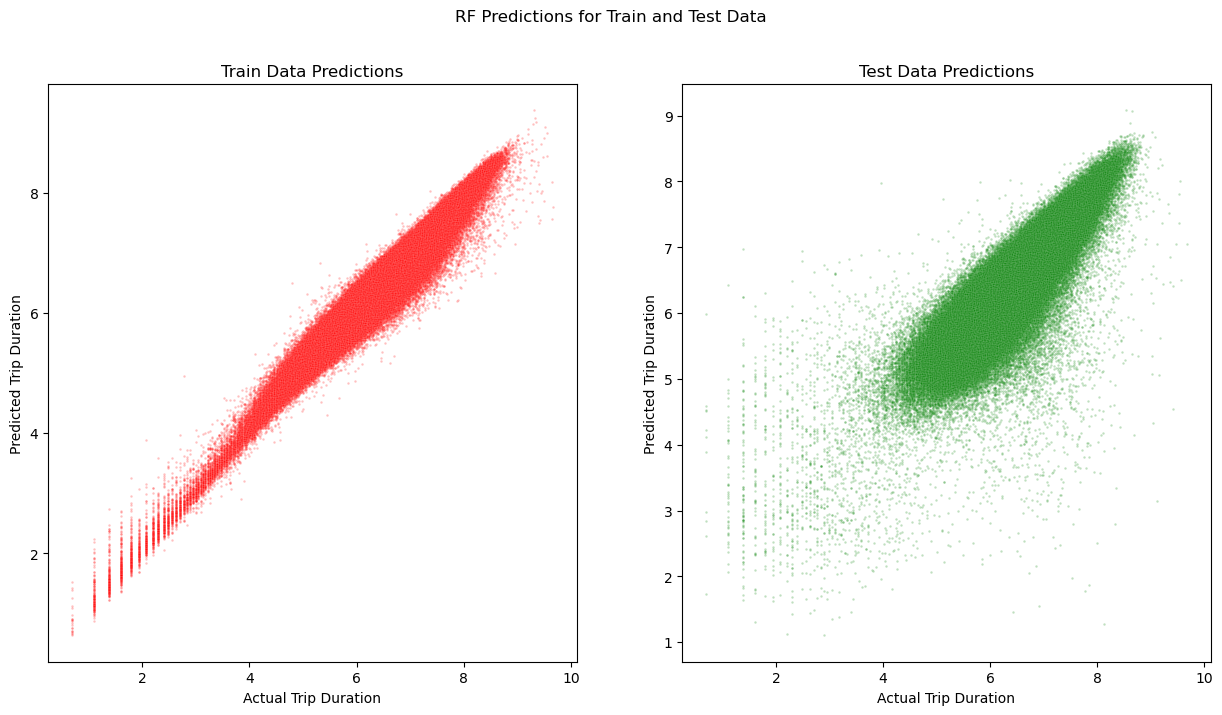

In [31]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7.5))
plt.suptitle('RF Predictions for Train and Test Data')
plt.subplot(1,2,1)
fig = sb.scatterplot(x = np.log(y_train+1),y = train_pred, s=3, color='red', alpha=0.25)
fig.set(title = "Train Data Predictions",xlabel='Actual Trip Duration',ylabel='Predicted Trip Duration')

plt.subplot(1,2,2)
fig = sb.scatterplot(x = np.log(y_test+1),y = test_pred, s=3, color='green', alpha=0.25)
fig.set(title = "Test Data Predictions",xlabel='Actual Trip Duration', ylabel='Predicted Trip Duration')
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
print(f'MSE: {round(mean_squared_error(np.log(y_train+1),train_pred,squared=False),3)}')
print(f'MAE: {round(mean_absolute_error(np.log(y_train+1),train_pred),3)}')
print(f'MSLE: {round(mean_squared_log_error(np.log(y_train+1),train_pred),3)}')
print(f'R^2: {round(r2_score(np.log(y_train+1),train_pred),3)}')
print(f'r: {round(np.corrcoef(np.log(y_train+1),train_pred)[0][1],3)}')

MSE: 0.151
MAE: 0.111
MSLE: 0.0
R^2: 0.962
r: 0.981


In [34]:
print(f'MSE: {round(mean_squared_error(np.log(y_test+1),test_pred,squared=False),3)}')
print(f'MAE: {round(mean_absolute_error(np.log(y_test+1),test_pred),3)}')
print(f'MSLE: {round(mean_squared_log_error(np.log(y_test+1),test_pred),3)}')
print(f'R^2: {round(r2_score(np.log(y_test+1),test_pred),3)}')
print(f'r: {round(np.corrcoef(np.log(y_test+1),test_pred)[0][1],3)}')

MSE: 0.377
MAE: 0.261
MSLE: 0.003
R^2: 0.763
r: 0.876


In [35]:
from pickle import dump
dump(xgb_model, open('xgb_best_model.pkl', 'wb'))

In [27]:
np.log(10)

2.302585092994046

In [ ]:
# error
def final_function2(mylist):
    st = time.time()
    train_data = pd.read_csv('preprocessed_train_data.csv')
    test_data = pd.read_csv('preprocessed_test_data.csv')
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(train_data.shape)
    print(test_data.shape)
    print("Reading train and test data. Done!!!")
    
    st = time.time()
    corrmat = np.round(train_data.corr(),3)
    upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
    to_drop.append('sqeuclidean_dist')
    noncoll_train_data = train_data.drop(to_drop,axis=1)
    noncoll_test_data = test_data.drop(to_drop,axis=1)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(noncoll_train_data.shape)
    print(noncoll_test_data.shape)
    print("Dropping columns to avoid collinearity problem. Done!!!")
    
    st = time.time()
    g = noncoll_train_data[['pickup_area','pickup_pop','dropoff_area','dropoff_pop']].values
    h = noncoll_test_data[['pickup_area','pickup_pop','dropoff_area','dropoff_pop']].values
    knn_imputer = KNNImputer(n_neighbors=3)
    st = time.time()
    new_train_data = knn_imputer.fit_transform(g)
    new_test_data = knn_imputer.transform(h)
    noncoll_train_data['pickup_area'] = new_train_data[::,0]
    noncoll_train_data['pickup_pop'] = new_train_data[::,1]
    noncoll_train_data['dropoff_area'] = new_train_data[::,2]
    noncoll_train_data['dropoff_pop'] = new_train_data[::,3]
    noncoll_test_data['pickup_area'] = new_test_data[::,0]
    noncoll_test_data['pickup_pop'] = new_test_data[::,1]
    noncoll_test_data['dropoff_area'] = new_test_data[::,2]
    noncoll_test_data['dropoff_pop'] = new_test_data[::,3]
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(noncoll_train_data.shape)
    print(noncoll_test_data.shape)
    print("Imputing missing data. Done!!!")
    
    st = time.time()
    ohe = OneHotEncoder(handle_unknown='ignore')
    categorical_features = ['passenger_count','vendor_id','store_and_fwd_flag','pickup_day','pickup_month','pickup_hour','pickup_weekyear','pickup_day_of_week','pickup_boro','pickup_nta','dropoff_boro','dropoff_nta']
    for i in categorical_features:
        noncoll_train_data[i]=noncoll_train_data[i].astype('object')
        noncoll_test_data[i]=noncoll_test_data[i].astype('object')  
    train_cat = noncoll_train_data.select_dtypes('object')
    test_cat = noncoll_test_data.select_dtypes('object')
    train_cat_features = ohe.fit_transform(train_cat).toarray()
    train_feature_names = ohe.get_feature_names_out(train_cat.columns.values)
    test_cat_features = ohe.transform(test_cat).toarray()
    test_feature_names = ohe.get_feature_names_out(test_cat.columns.values)
    train_ohe = pd.concat([noncoll_train_data.select_dtypes(exclude='object'), 
            pd.DataFrame(train_cat_features,columns=train_feature_names).astype(int)], axis=1)
    test_ohe = pd.concat([noncoll_test_data.select_dtypes(exclude='object'), 
            pd.DataFrame(test_cat_features,columns=test_feature_names).astype(int)], axis=1)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(train_ohe.shape)
    print(test_ohe.shape)
    print("Converting categorical to numerical features. Done!!!")
    
    st = time.time()
    X_train_ohe = train_ohe.drop(['trip_duration'],axis=1)
    X_test_ohe = test_ohe.drop(['trip_duration'],axis=1)
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train_ohe)
    X_test_ss = ss.transform(X_test_ohe)
    y_train = train_ohe['trip_duration'].values
    y_test = test_ohe['trip_duration'].values
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    print(X_train_ss.shape)
    print(X_test_ss.shape)
    print("Feature Scaling. Done!!!")
    
    st = time.time()
    #train_dmatrix = xgb.DMatrix(data = X_train_ss.values, label = np.log(y_train+1), feature_names=final_features)
    #test_dmatrix = xgb.DMatrix(data = X_test_ss.values, label = np.log(y_test+1), feature_names=final_features)
    xgb_model_loaded = pickle.load(open("best_xgb_r.pkl", "rb"))
    final_features = X_train_ohe.columns.values    
    new_test_dmatrix = xgb.DMatrix(data = X_test_ohe.values[mylist], label = np.log(y_test[mylist]+1), feature_names=final_features)
    best_test_pred_new = xgb_model_loaded.predict(new_test_dmatrix)
    msle = mean_squared_log_error(np.log(y_test[mylist]+1),best_test_pred_new)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')  
    print("Loading saved model and predicting test data. Done!!!")    

    return msle

In [ ]:
random_samples = random.sample(range(1, len(test_data)), 30)
errors = final_function2(random_samples)

In [ ]:
errors